In [1]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

In [2]:
def hist_of_numerical_values(df: pl.DataFrame):
    """
    Generates histograms for all numerical columns in a Polars DataFrame.

    Args:
        df: The Polars DataFrame.

    Returns:
        A dictionary where keys are column names and values are the histogram data.
    """
    histograms = {}
    for col_name in df.columns:
        if df[col_name].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]:
            hist_data = df[col_name].hist()
            histograms[col_name] = hist_data
    return histograms

In [88]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    15: [],
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 19, 21, 22]

In [92]:
# for query_ind in queries_to_run:
num_trials = 1000
avg_errors = {}
all_nulls = {}
for query_ind in [3]:
#     1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0
    num_nulls = 0.
    total_error = []
    for mi in [1/16]:
        null_info = {}
        orig = pl.read_csv(f'unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        noised = pl.read_json(f'outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        if query_ind == 15:
            base_names = ['total_revenue'] # only look at numeric
        all_outputs = 0.
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    noised_vals = [merged_df[noised][ind][tmp_ind] for tmp_ind in range(
                        len(merged_df[noised][ind])) if merged_df[noised][ind][tmp_ind] is not None]
                    new = np.average(
                        [100*abs(
                            const*noised_vals[tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(noised_vals))]
                    )
                    if not np.isnan(new):
                        total_error.append(new)
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                num_outputs = len(list(merged_df[noised]))
                all_outputs+= num_outputs
                for ind in range(num_outputs):
                    full_list = [x for x in list(merged_df[noised][ind]) if x is not None]
                    if len(full_list) < num_trials:
                        num_nulls += 1
                        nulls_exist = True
                        null_inds.append(ind)
                        null_vals.append(100*(num_trials-len(full_list))/num_trials)
#                         print(query_ind, ind, null_vals)
            null_info[base_name] = (nulls_exist, null_inds, null_vals)
        all_nulls[query_ind] = 100*num_nulls/all_outputs
        avg_errors[query_ind] = np.average(total_error)

#         # Get columns that start with 'pct_diff'
#         pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]

#         # Create subplots based on number of pct_diff columns
#         n_cols = len(pct_diff_cols)
#         fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))

#         # Handle case where there's only one column (axes won't be a list)
#         if n_cols == 1:
#             axes = [axes]

#         # Create histogram for each column
#         for i, col in enumerate(pct_diff_cols):
#             # Convert to pandas for easier plotting, or use polars plot method
#             values = merged_df[col].to_pandas()

#             axes[i].hist(values, bins=30, alpha=0.7, edgecolor='black')
#             axes[i].set_title(f'Histogram of {col}')
#             axes[i].set_xlabel(col)
#             axes[i].set_ylabel('Frequency')
#             axes[i].grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.savefig(f'tmp/q{query_ind}_{mi}_{col}_hist.png', facecolor='white', bbox_inches='tight')

#         for base in null_info:
#             (nulls_exist, null_inds, null_vals) = null_info[base]
#             if nulls_exist:
#                 fig, axes = plt.subplots(1, 1, figsize=(5, 4))
#                 # Handle case where there's only one column (axes won't be a list)
#                 if n_cols == 1:
#                     axes = [axes]
#                 axes[0].hist(null_vals, bins=30, alpha=0.7, edgecolor='black')
#                 axes[0].set_title(f'Histogram of nulls for column {base}')
#                 axes[0].set_xlabel('Fraction of nulls (%)')
#                 axes[0].set_ylabel('Frequency')
#                 axes[0].grid(True, alpha=0.3)
#                 plt.savefig(f'tmp/q{query_ind}_{mi}_{base}_nulls.png', facecolor='white', bbox_inches='tight')

In [93]:
merged_df

l_orderkey,revenue,o_orderdate,o_shippriority,revenue_noised,pct_diff_revenue
i64,f64,str,i64,list[null],f64
223140,355369.0698,"""1995-03-14""",0,[null],NaN
554757,349181.7426,"""1995-03-14""",0,[null],NaN
108514,314967.0754,"""1995-02-20""",0,[null],NaN
462502,312604.542,"""1995-03-08""",0,[null],NaN
178727,309728.9306,"""1995-02-25""",0,[null],NaN
584291,354494.7318,"""1995-02-21""",0,[null],NaN
573861,351238.277,"""1995-03-09""",0,[null],NaN
506021,321075.581,"""1995-03-10""",0,[null],NaN
405063,353125.4577,"""1995-03-03""",0,[null],NaN


In [90]:
avg_errors

{1: 2.5442233968173715,
 3: nan,
 4: 7.967681478360539,
 5: 25.622938327248313,
 6: 3.975880395383505,
 7: 26.254870522345144,
 8: 120.43882910564585,
 9: 23.271514480779384,
 12: 9.28002866295529,
 13: 19.722793014350138,
 14: 7.293048263023766,
 15: 41.89916745531556,
 17: 39.95207812726525,
 19: 85.3515578953771,
 21: 68.63134006957296,
 22: 25.083121818619354}

In [91]:
all_nulls

{1: 0.0,
 3: 100.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 12: 0.0,
 13: 13.513513513513514,
 14: 0.0,
 15: 0.0,
 17: 0.0,
 19: 0.0,
 21: 51.06382978723404,
 22: 0.0}

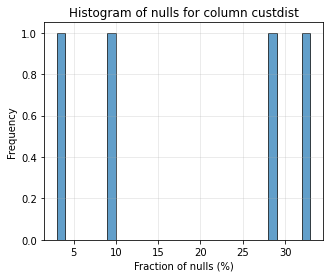